In [2]:
import numpy as np

# Exponenciálisan lecsengő függvény illesztése az adatokra

In [37]:
x = np.genfromtxt('x.txt')

In [38]:
y = np.genfromtxt('y.txt')

In [14]:
print x.shape
print y.shape

(7999,)
(7999,)


In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

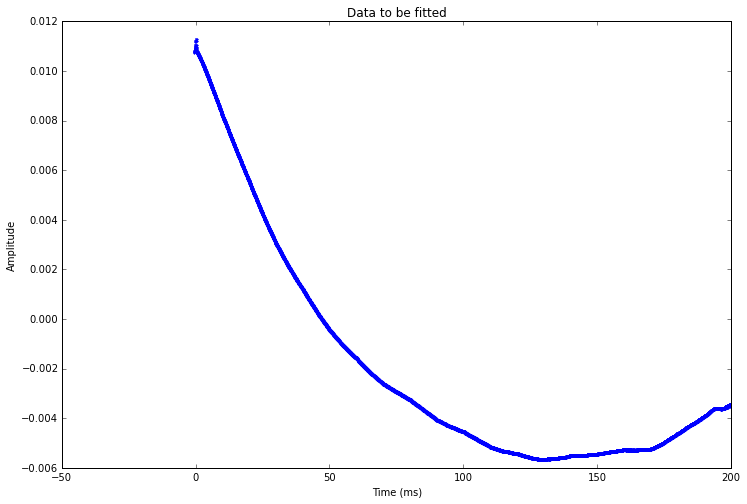

In [34]:
plt.figure(figsize=(12,8))
plt.title('Data to be fitted')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.plot(x[3999:],y[3999:], '.')
plt.show()

In [39]:
x = x[3999:]
y = y[3999:]

In [40]:
from scipy.optimize import curve_fit

In [44]:
def func(t, D, lamb):
    return D*lamb*np.exp(-t*lamb)

p_init = [1, 0.01]

p_opt, p_cov = curve_fit(func, x, y, p0=p_init)
p_err = np.sqrt(np.diag(p_cov))
print "Optimized parameters: " + str(p_opt)
print "Error of the fitting: " + str(p_err)

Optimized parameters: [ 0.22540898  0.06061858]
Error of the fitting: [ 0.00717439  0.00272444]


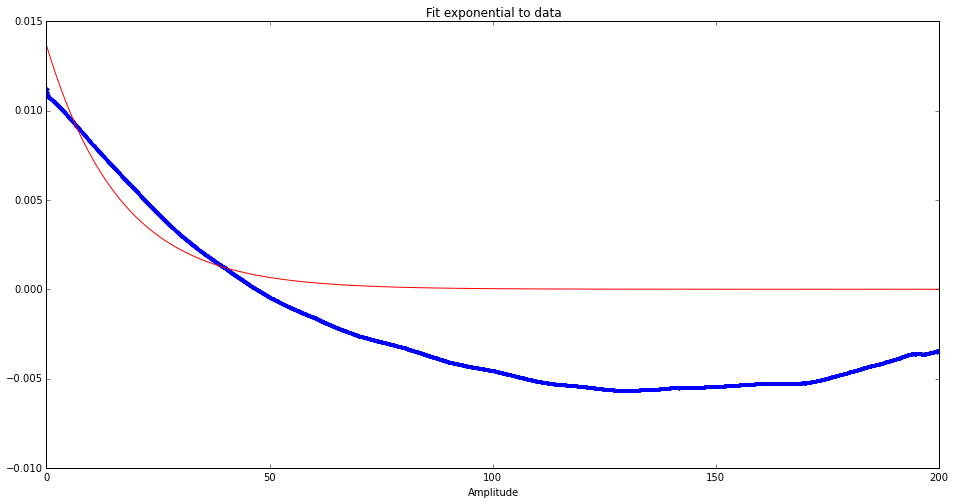

In [50]:
tt = np.linspace(0,200,200000)
plt.figure(figsize=(16,8))
plt.title('Fit exponential to data')
plt.xlabel('Time (ms)')
plt.xlabel('Amplitude')
plt.plot(x,y, '.')
plt.plot(tt, func(tt, *p_opt), 'r-')
plt.show()

### Láthatóan ez nem túl jó. 
# Adatok eltolása pozitív tarományba

In [51]:
y_pos = np.subtract(y, np.min(y))

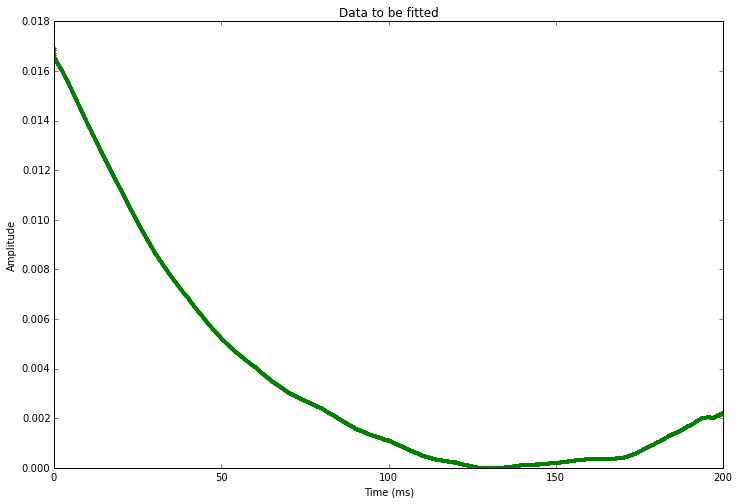

In [53]:
plt.figure(figsize=(12,8))
plt.title('Data to be fitted')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.plot(x,y_pos, 'g.')
plt.show()

Végezzük el erre az illesztést

In [61]:

p_opt2, p_cov2 = curve_fit(func, x, y_pos, p0=p_init)
p_err2 = np.sqrt(np.diag(p_cov2))
print "Optimized parameters: " + str(p_opt2)
print "Error of the fitting: " + str(p_err2)

Optimized parameters: [ 0.71419764  0.02483981]
Error of the fitting: [  1.76735086e-03   8.69614998e-05]


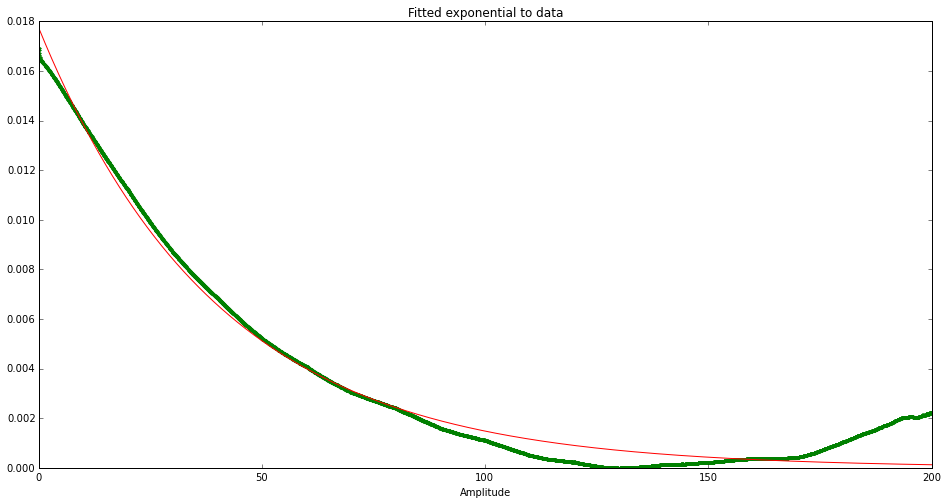

In [65]:

plt.figure(figsize=(16,8))
plt.title('Fitted exponential to data')
plt.xlabel('Time (ms)')
plt.xlabel('Amplitude')
plt.plot(x,y_pos, 'g.')
plt.plot(tt, func(tt, *p_opt2), 'r-')
plt.show()

Ez már sokkal jobban illeszkedik!

# Eredmények
### Eredeti adatokra:
    Optimized parameters: [ D = 0.22540898  lamb = 0.06061858]
    Error of the fitting: [ 0.00717439  0.00272444] 

### Eltolt adatokra:
    Optimized parameters: [ D = 0.71419764  lamb = 0.02483981] 
    Error of the fitting: [  1.76735086e-03   8.69614998e-05] 

# Más függvények illesztése


## Exponenciális kiegészítve egy negatív gaussal
    D*lamb*Exp[-lamb*x] - A*Exp[-(x - mu)^2/(2sig^2)] alak

In [54]:
def func2(t, D, lamb, A, mu, sig):
    return D*lamb*np.exp(-t*lamb) - A*np.exp(-(t-mu)**2/(2*sig**2))

p_init3 = [0.22540898, 0.06061858, 0.005, 130, 50]

p_opt3, p_cov3 = curve_fit(func2, x, y, p0=p_init3)
p_err3 = np.sqrt(np.diag(p_cov3))
print "Optimized parameters: " + str(p_opt3)
print "Error of the fitting: " + str(p_err3)

Optimized parameters: [  4.55090676e-01   2.82009826e-02   5.89036519e-03   1.28340772e+02
   7.38233398e+01]
Error of the fitting: [  2.81405483e-03   1.48154153e-04   6.76182117e-06   2.16498168e-01
   2.78640239e-01]


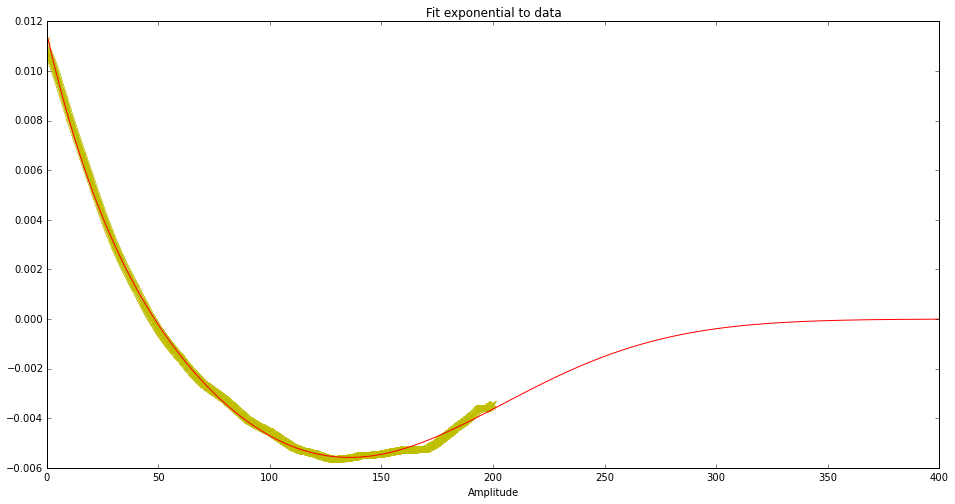

In [60]:
tt3 = np.linspace(0,400,20000)
plt.figure(figsize=(16,8))
plt.title('Fit exponential with gauss to data')
plt.xlabel('Time (ms)')
plt.xlabel('Amplitude')
plt.plot(x,y, 'yx')
plt.plot(tt3, func2(tt3, *p_opt3), 'r-')
plt.show()

Az a kérdés hogyan tart vissza a függvény a nullába? Hosszabb adatsor?

# Zaj generálása ötlet


Ha vesszük ezt a jól illeszkedű autocorrelációs függvényalakot, zajt nem tudunk a segítségével generálni, viszont kovarianciamátrixot igen. 

Ha realisztikus zajt szeretnénk előállítani mi lehet a megoldás? A zaj lehet bonyolult nemlineáris sémát követ, amire betanítható lenne egy mély neurális hálózat. Bemenetként rengeteg zaj adatot kap és kimenetként elvárjuk, hogy előálljon a bemeneti zaj. Így beállítva a hálózatot kísérleti zaj-generátor válhat belőle.

# Illesztett exponenciális zajmodell vizsgálata
## Mennyire hasonlít a determinisztikus függvényre rakott illesztett zaj a valós kísérleti adatokra?

In [61]:
from neuron import h, gui

In [63]:
# --- Load experimental trace
experimental_trace = np.genfromtxt("./resampled_experimental_trace")
t = experimental_trace[:, 0]
exp_v = experimental_trace[:, 1]

In [64]:
# --- Define simulation protocol
def exp_model(Ra=157.3621, gpas=0.000403860792, cm=7.849480, dt=0.1):
    # -- Biophysics --
    # Sec parameters and conductance
    for sec in h.allsec():
        sec.Ra = Ra  # Ra is a parameter to infer
        sec.cm = cm   # parameter optimisation algorithm found this
        sec.v = 0

        sec.insert('pas')
        sec.g_pas = gpas  # gpas is a parameter to infer
        sec.e_pas = 0

    # Print information
    #h.psection()

    # Stimulus
    stim1 = h.IClamp(h.soma(0.01))
    stim1.delay = 200
    stim1.amp = 0.5
    stim1.dur = 2.9

    stim2 = h.IClamp(h.soma(0.01))
    stim2.delay = 503
    stim2.amp = 0.01
    stim2.dur = 599.9

    # Run simulation ->
    # Set up recording Vectors
    v_vec = h.Vector()  # Membrane potential vector
    t_vec = h.Vector()  # Time stamp vector
    v_vec.record(h.soma(0.5)._ref_v)
    t_vec.record(h._ref_t)

    # Simulation duration and RUN
    h.tstop = 1200  # Simulation end
    h.dt = dt  # Time step (iteration)
    h.steps_per_ms = 1 / dt
    h.v_init = 0
    h.finitialize(h.v_init)

    h.init()
    h.run()

    t = t_vec.to_python()
    v = v_vec.to_python()

    return t, v

In [65]:
# --- Load NEURON morphology
h('load_file("./morphology_131117-C2.hoc")')
# Set the appropriate "nseg"
for sec in h.allsec():
    sec.Ra = 180
h('forall {nseg = int((L/(0.1*lambda_f(100))+.9)/2)*2 + 1}')  # If Ra_max = 105 dend.nseg = 21 and soma.nseg = 1

1

In [77]:
# Simulating deterministic data
_, v_det = exp_model()

In [70]:
# Create noise
from math import sqrt, log, cos, pi, exp
def colored(D, lamb, dt, v_vec):
    """Returns the given array with colored noise as numpy array"""
    noise = []
    n, m = np.random.uniform(0.0, 1.0, 2)
    E = exp(-lamb * dt)
    e_0 = sqrt(-2 * D * lamb * log(m)) * cos(2 * pi * n)
    noise.append(e_0)

    for i in range(len(v_vec) - 1):
        a, b = np.random.uniform(0.0, 1.0, 2)
        h = sqrt(-2 * D * lamb * (1 - E ** 2) * log(a)) * cos(2 * pi * b)
        e_next = e_0 * E + h
        noise.append(e_next)
        e_0 = e_next

    return np.add(v_vec, noise)

In [78]:
# Create noised data (with fitted parameters)
v_noised = colored(0.22540898, 0.06061858, 0.1, v_det)

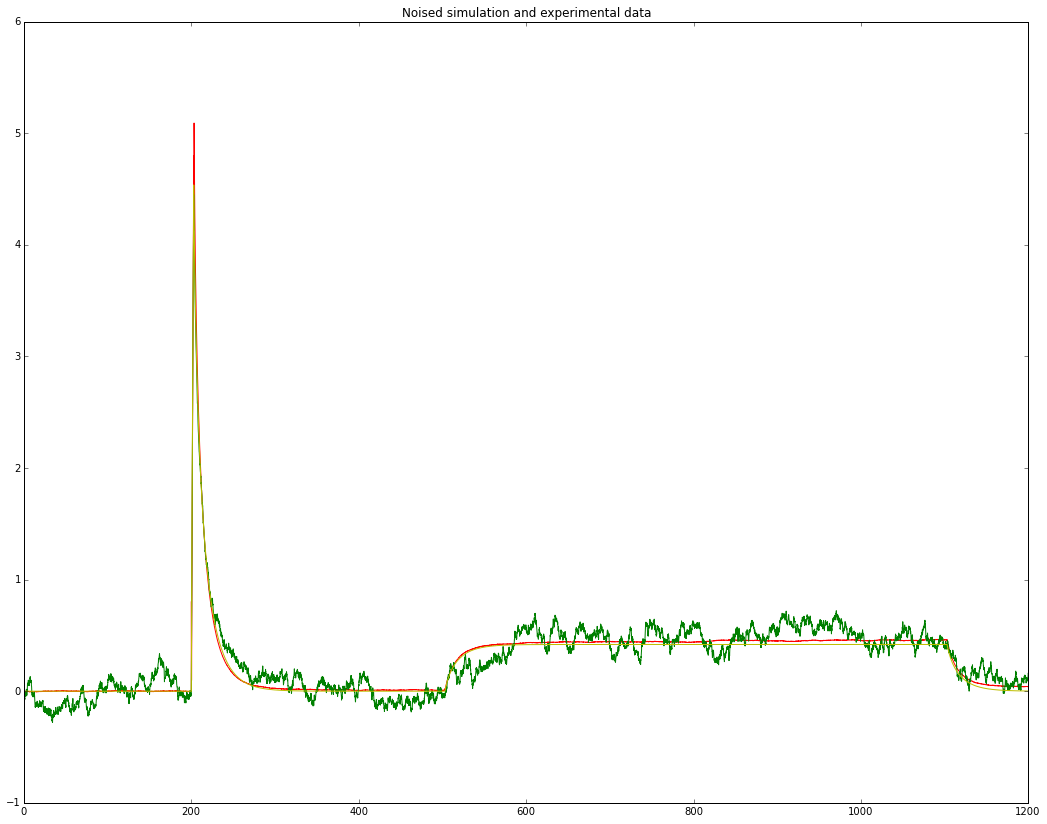

In [80]:
plt.figure(figsize=(18,14))
plt.title('Noised simulation and experimental data')
plt.plot(t, exp_v, 'r')
plt.plot(t, v_noised, 'g')
plt.plot(t, v_det, 'y')
plt.show()

Érdekes módon sokkal nagyobb zajt generál, mint ami a valós adatsoron van.

# Szimuláció végzése 
## A gaussal kiegészített zajmodellel generált kovarianciamátrixot felhasználva.

A szimuláció eredményei itt találhatóak: 